In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline

In [3]:
df=pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
X= df.drop(columns=["PassengerId","Name"])
y=df["Transported"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [5]:
X

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False


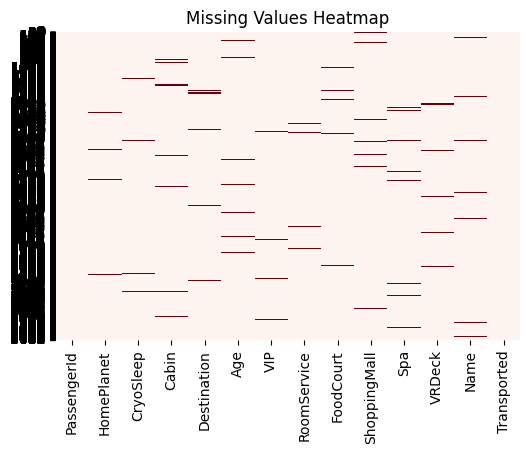

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 4))
sns.heatmap(df.isnull(), cmap="Reds", cbar=False, yticklabels=True)
plt.title("Missing Values Heatmap")
plt.show()

In [7]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # handle NaNs
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))    # encode after imputin
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))  # fill NaNs
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_pipeline, ["HomePlanet","CryoSleep","Cabin","Destination","VIP"]),
    ("num",num_pipeline,["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"])
])

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC()
}

In [9]:
best_model_name = None
best_score = 0
best_estimator = None

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
    print(f'{name} CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}')

    if scores.mean() > best_score:
        best_score = scores.mean()
        best_model_name = name
        best_estimator = pipe

print(f"\n✅ Best model: {best_model_name} with accuracy: {best_score:.3f}")

LogisticRegression CV Accuracy: 0.781 ± 0.012
RandomForest CV Accuracy: 0.780 ± 0.010
SVC CV Accuracy: 0.720 ± 0.015

✅ Best model: LogisticRegression with accuracy: 0.781


In [10]:
best_estimator.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Cabin', 'Destination',
                                                   'VIP']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

+++++++++++++++++++++++++++++++++++++TEST+++++++++++++++++++++++++++++++++++++++

In [11]:
df = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [12]:
X= df.drop(columns=["PassengerId","Name"])

In [13]:
X

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0
4273,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0
4274,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0
4275,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0


In [14]:
predictions = best_estimator.predict(X)

In [15]:
submission = pd.DataFrame({
    "PassengerId": df["PassengerId"],
    "Transported": predictions.astype(bool)  # Make sure it's True/False not 1/0
})

submission.to_csv("submission.csv", index=False)
print("📁 Saved submission.csv for Kaggle")

📁 Saved submission.csv for Kaggle
